1. Dataset Preparation:
  - Download the dataset from Kaggle.
  - Load the dataset and explore the columns to understand the structure.
  - Concatenate multiple poems into a single text corpus, separating them by
    newline characters for clarity.

In [3]:
import pandas as pd

df = pd.read_csv('/content/PoetryFoundationData.csv')
print(df.head())
print(df.columns)
print(df.info())

   Unnamed: 0                                              Title  \
0           0  \r\r\n                    Objects Used to Prop...   
1           1  \r\r\n                    The New Church\r\r\n...   
2           2  \r\r\n                    Look for Me\r\r\n   ...   
3           3  \r\r\n                    Wild Life\r\r\n     ...   
4           4  \r\r\n                    Umbrella\r\r\n      ...   

                                                Poem              Poet Tags  
0  \r\r\nDog bone, stapler,\r\r\ncribbage board, ...  Michelle Menting  NaN  
1  \r\r\nThe old cupola glinted above the clouds,...     Lucia Cherciu  NaN  
2  \r\r\nLook for me under the hood\r\r\nof that ...        Ted Kooser  NaN  
3  \r\r\nBehind the silo, the Mother Rabbit\r\r\n...   Grace Cavalieri  NaN  
4  \r\r\nWhen I push your button\r\r\nyou fly off...      Connie Wanek  NaN  
Index(['Unnamed: 0', 'Title', 'Poem', 'Poet', 'Tags'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13

2. Data Preprocessing:
    - Convert the text to lowercase and remove special characters or
      punctuation if necessary.
    - Tokenize the text (e.g., convert each word to a unique integer).
    - Use a sliding window to create sequences of words for the LSTM model.
      For example, if n=5, create sequences of 5 words with the 6th word as the
      target.
    - Pad the sequences so that they all have the same length.

In [4]:
import re

corpus = "\n".join(df['Poem'].dropna().astype(str)).lower()
corpus = re.sub(r'[^\w\s]', '', corpus)
corpus = list(set(corpus.split()))
corpus = " ".join(corpus)
print(corpus[:500])

cansedging powwow faces muttless suspiciouswe archetype pebblepaven cataracting livingone pupilthe darkemans dumbbellshaped chada winderoded pawnbrokers eres bilderbergers machine miscarriages birthpouf footing hearty needleman salutation to ruffled ransacked fullscale puzzles funneling blowdried peepd shoresleaves folderols dazes looped flavoralarming surmise eyescan gethsemanes compressing advisd someplacebeyond monitordrooping 1572 alms heavenfor alonei élysées stepsshe moody kinda faiththat 


In [5]:
from collections import defaultdict

def tokenize(text):
  word_to_int = defaultdict(lambda: len(word_to_int))
  tokens = [word_to_int[word] for word in text.split()]
  return tokens, word_to_int

tokens, word_to_int = tokenize(corpus)
print(tokens[:100])
print(len(word_to_int))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
145778


In [6]:
import numpy as np

def create_sequences(tokens, n=5):
    sequences = []
    for i in range(len(tokens) - n):
        sequence = tokens[i:i + n]
        target = tokens[i + n]
        sequences.append((sequence, target))
    return sequences

sequences = create_sequences(tokens)
print(sequences[:10])


def pad_sequences(sequences, maxlen=None):
    if maxlen is None:
        maxlen = max([len(seq[0]) for seq in sequences])
    padded_sequences = []
    targets = []
    for seq, target in sequences:
        padded_seq = seq + [0] * (maxlen - len(seq))
        padded_sequences.append(padded_seq)
        targets.append(target)

    return np.array(padded_sequences), np.array(targets)

padded_sequences, targets = pad_sequences(sequences)
print(padded_sequences[:10])
print(targets[:10])

print(padded_sequences.shape)
targets.shape

[([0, 1, 2, 3, 4], 5), ([1, 2, 3, 4, 5], 6), ([2, 3, 4, 5, 6], 7), ([3, 4, 5, 6, 7], 8), ([4, 5, 6, 7, 8], 9), ([5, 6, 7, 8, 9], 10), ([6, 7, 8, 9, 10], 11), ([7, 8, 9, 10, 11], 12), ([8, 9, 10, 11, 12], 13), ([9, 10, 11, 12, 13], 14)]
[[ 0  1  2  3  4]
 [ 1  2  3  4  5]
 [ 2  3  4  5  6]
 [ 3  4  5  6  7]
 [ 4  5  6  7  8]
 [ 5  6  7  8  9]
 [ 6  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 12]
 [ 9 10 11 12 13]]
[ 5  6  7  8  9 10 11 12 13 14]
(145773, 5)


(145773,)

3. LSTM Model Development:
- Define an LSTM model with the following structure:
  - An embedding layer with an appropriate input dimension (based
    on vocabulary size) and output dimension (e.g., 100).
  - One or two LSTM layers with 100 units each.
  - A dropout layer with a rate of 0.2 to prevent overfitting.
  - A dense output layer with softmax activation for word prediction.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

vocab_size = len(word_to_int)
embedding_dim = 100
lstm_units = 100
dropout_rate = 0.2

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=padded_sequences.shape[1]))
model.add(LSTM(lstm_units, return_sequences=True))  # Return sequences for stacked LSTM
model.add(LSTM(lstm_units)) # Second LSTM layer
model.add(Dropout(dropout_rate))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

4. Training:
  - Compile the model with categorical cross-entropy as the loss function
  and accuracy as the metric.
  - Train the model on the sequences for 10-20 epochs (or until it achieves
  satisfactory performance).

In [8]:
model.fit(padded_sequences, targets, epochs=5) # Train for 5 epochs

Epoch 1/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 266s 57ms/step - accuracy: 0.0000e+00 - loss: 12.1419
Epoch 2/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 316s 56ms/step - accuracy: 0.0000e+00 - loss: 12.1589
Epoch 3/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 258s 57ms/step - accuracy: 0.0000e+00 - loss: 11.7922
Epoch 4/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 261s 56ms/step - accuracy: 1.6415e-04 - loss: 10.9202
Epoch 5/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 261s 57ms/step - accuracy: 0.0024 - loss: 9.7211


5. Text Generation:
  - After training, write a function to generate new poetry lines:
      - Start with a seed text (e.g., a short phrase).
      - Predict the next word, append it to the seed text, and use this
        updated text to predict the following word.
      - Repeat this process for a specified number of words or lines.
  - Generate multiple lines of poetry using different starting phrases.

In [9]:
def generate_poetry(seed_text, num_words, model, word_to_int, int_to_word):
    generated_text = seed_text.lower()
    for _ in range(num_words):
        token_list = tokenize(generated_text)[0][-5:] # Get last 5 words
        token_list = token_list + [0]*(5 - len(token_list)) # pad sequence
        token_list = np.array([token_list])
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_id = np.random.choice(len(predicted_probs), p=predicted_probs)
        predicted_word = int_to_word[predicted_id]
        generated_text += " " + predicted_word
    return generated_text

int_to_word = {value: key for key, value in word_to_int.items()}

# Example usage:
seed_texts = ["the world is", "love is", "in the night"]
num_words_to_generate = 10

for seed_text in seed_texts:
    generated_poem = generate_poetry(seed_text, num_words_to_generate, model, word_to_int, int_to_word)
generated_poem

'in the night anseladams awakemy disburdening showdowns assureidentityone surly eyesfor suitswalking tears 80some'

6. Evaluation and Experimentation:
  - Experiment with different LSTM layer sizes, dropout rates, and sequence
    lengths to observe their effects on generated text quality.
  - Try adding additional LSTM layers and tuning hyperparameters to improve
    the creativity or fluency of generated poetry.

Experimenting with LSTM units: 50
Epoch 1/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 245s 53ms/step - accuracy: 0.0000e+00 - loss: 12.1556
Epoch 2/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 260s 53ms/step - accuracy: 0.0000e+00 - loss: 12.1464
Epoch 3/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 263s 53ms/step - accuracy: 0.0000e+00 - loss: 11.5642
Epoch 4/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 263s 53ms/step - accuracy: 1.4168e-04 - loss: 10.8093
Epoch 5/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 262s 53ms/step - accuracy: 7.1564e-04 - loss: 10.2022


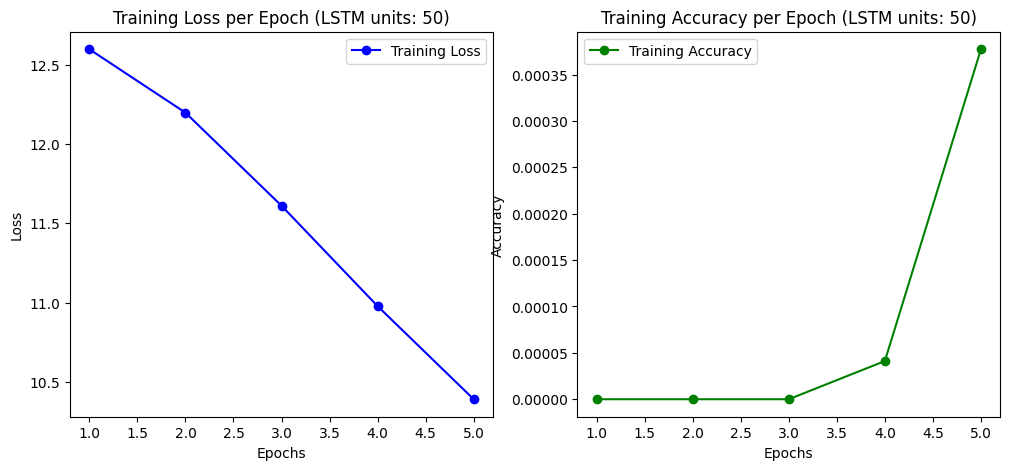

Experimenting with LSTM units: 150
Epoch 1/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 283s 61ms/step - accuracy: 0.0000e+00 - loss: 12.1304
Epoch 2/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 323s 62ms/step - accuracy: 0.0000e+00 - loss: 12.1381
Epoch 3/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 323s 62ms/step - accuracy: 5.7465e-06 - loss: 11.6064
Epoch 4/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 320s 62ms/step - accuracy: 1.7193e-04 - loss: 10.6932
Epoch 5/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 281s 62ms/step - accuracy: 0.0029 - loss: 9.4491


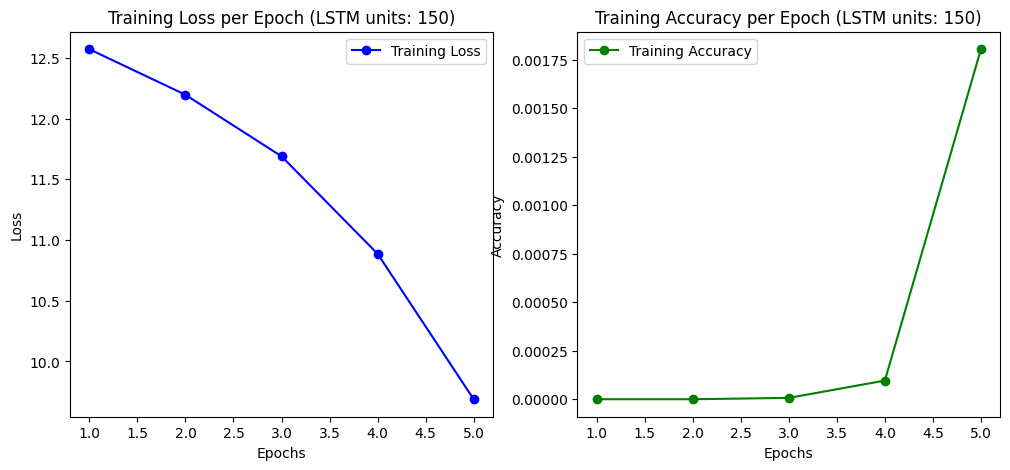

Experimenting with LSTM units: 200
Epoch 1/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 309s 67ms/step - accuracy: 0.0000e+00 - loss: 12.1303
Epoch 2/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 322s 67ms/step - accuracy: 0.0000e+00 - loss: 12.0704
Epoch 3/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 322s 67ms/step - accuracy: 6.7462e-07 - loss: 11.7113
Epoch 4/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 307s 67ms/step - accuracy: 6.6185e-05 - loss: 11.1578
Epoch 5/5
4556/4556 ━━━━━━━━━━━━━━━━━━━━ 322s 67ms/step - accuracy: 0.0013 - loss: 10.1698


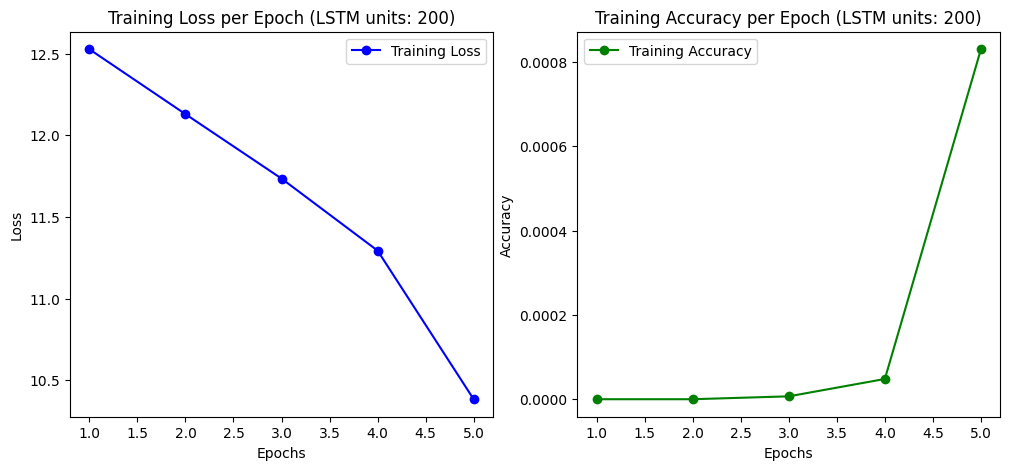

Experimenting with dropout rate: 0.1
Epoch 1/5
2113/4556 ━━━━━━━━━━━━━━━━━━━━ 2:44 67ms/step - accuracy: 0.0000e+00 - loss: 11.9225

KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt



# Function to plot training loss and accuracy
def plot_metrics(history, title_suffix=""):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per Epoch {title_suffix}')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], 'go-', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training Accuracy per Epoch {title_suffix}')
    plt.legend()

    plt.show()

# Experimenting with different LSTM layer sizes
lstm_units_list = [50, 150, 200]
for lstm_units in lstm_units_list:
    print(f"Experimenting with LSTM units: {lstm_units}")
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=padded_sequences.shape[1]))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model and capture the history for plotting
    history = model.fit(padded_sequences, targets, epochs=5)

    # Plot loss and accuracy
    plot_metrics(history, title_suffix=f"(LSTM units: {lstm_units})")

